In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

In [5]:
meta = pd.concat([
    pd.read_csv("../../metadata/supp1_tab2.csv"), 
    pd.read_csv("../../metadata/supp1_tab4.csv")
], ignore_index=True)
#remove samples failing QC
meta = meta.query('subset_1 == "Y" or country == "Burkina Faso"')
meta.head()

,sample_id,contributor,country,location,collection_year,collection_month,latitude,longitude,date_of_collection,collection_context,...,mismatches,error_rate,average_quality,insert_size_average,insert_size_standard_deviation,inward_oriented_pairs,outward_oriented_pairs,pairs_with_other_orientation,pairs_on_different_chromosomes,ena_run_accessions
0,VBS17190,Charles Wondji,Cameroon,Mibellon,2014,8,6.083333,11.5,1/8/2014,Indoor,...,283588237.0,0.0275,36.9,649.3,1177.6,32411375.0,1042230.0,329372.0,1609379.0,"ERR2659589,ERR2659624,ERR2659659"
1,VBS17191,Charles Wondji,Cameroon,Mibellon,2014,8,6.083333,11.5,1/8/2014,Indoor,...,282854658.0,0.0283,36.8,635.5,1134.0,31615351.0,844567.0,307370.0,1453795.0,"ERR2659820,ERR2659855,ERR2659890"
2,VBS17192,Charles Wondji,Cameroon,Mibellon,2014,8,6.083333,11.5,1/8/2014,Indoor,...,286495654.0,0.0272,37.2,611.8,1164.8,33223916.0,982688.0,342987.0,1664748.0,"ERR2659709,ERR2659744,ERR2659779"
3,VBS17193,Charles Wondji,Cameroon,Mibellon,2014,8,6.083333,11.5,1/8/2014,Indoor,...,274678395.0,0.0270,37.3,625.6,1153.4,32041874.0,973405.0,322974.0,1597513.0,"ERR2659293,ERR2659328,ERR2659363"
4,VBS17195,Charles Wondji,Cameroon,Mibellon,2014,8,6.083333,11.5,1/8/2014,Indoor,...,278710855.0,0.0285,36.7,662.4,1152.8,30891448.0,893728.0,304329.0,1489823.0,"ERR2659805,ERR2659840,ERR2659875"


In [3]:
def geo_dist(geo1, geo2):
    
    #convert to radians
    f1,l1,f2,l2 = convert_to_radians(np.concatenate([geo1, geo2]))
    fm = (f1+f2)/2
    R = 6371.009
    d_s_cord = 2 * np.sqrt(np.sin((f1-f2)/2)**2 + np.cos(f1)*np.cos(f2)*np.sin((l1-l2)/2)**2)
    D = R * 2 * np.arcsin(d_s_cord/2)
    return D
    
def convert_to_radians(x):
    x *= np.pi/180
    return x

def compute_distances(coord):
    
    geo_dist_mat = pd.DataFrame(index=coord.index, columns=coord.index)
    for i, loc1 in enumerate(coord.index[:-1]):
        for loc2 in coord.index[i+1:]:
            geo_dist_mat.loc[loc2, loc1] = geo_dist(coord.loc[loc1], coord.loc[loc2])
            #put log in the upper triangle
            geo_dist_mat.loc[loc1, loc2] = np.log(geo_dist_mat.loc[loc2, loc1])
    return geo_dist_mat
    

In [4]:
#ratio of means table as computed in fst, but also containing Kiribina and Folonzo samples
fst = pd.read_csv("Fst_2L.tsv", sep='\t', index_col=0)
fst.head()

,GH-N,BJ,BF-K,BF-F,GH-A,NG,CM,CF,CD-H,UG,KE-W,KE-N,GA,CD-K,TZ,MZ-C,ZM,MW,MZ-M
GH-N,NaN,0.152805,0.124437,0.094628,0.152045,0.140538,0.119540,0.118281,0.108421,0.108100,0.106206,0.109900,0.189473,0.190795,0.181838,0.188394,0.176773,0.178658,0.217654
BJ,0.0,NaN,0.052583,0.039234,0.101491,0.090292,0.065929,0.057914,0.061054,0.063462,0.077887,0.061601,0.141147,0.132465,0.123031,0.125038,0.120302,0.122933,0.151600
BF-K,0.0,0.000000,NaN,0.022051,0.076269,0.065525,0.042143,0.034499,0.037398,0.039450,0.053435,0.037730,0.114017,0.105967,0.096915,0.098882,0.094251,0.096748,0.124427
BF-F,0.0,0.000000,0.000000,NaN,0.060327,0.049034,0.025558,0.020304,0.017586,0.018317,0.025174,0.018413,0.095922,0.092306,0.083150,0.087129,0.079459,0.081572,0.114737
GH-A,0.0,0.000000,0.000000,0.000000,NaN,0.010694,0.046697,0.053640,0.054867,0.072621,0.080624,0.064830,0.101908,0.109101,0.132522,0.132193,0.126903,0.132532,0.163298


In [19]:
coord = meta.groupby(['geographic_cohort_code'])[['latitude', 'longitude']].mean()
#order coordinates as fst
coord = coord.loc[fst.index]
coord

,latitude,longitude
GH-N,9.461873,-0.968661
BJ,6.383333,2.200000
BF-K,11.951688,-1.185974
BF-F,12.081900,-1.730200
GH-A,5.933333,-1.616667
NG,6.950000,3.716667
CM,6.083333,11.500000
CF,4.376666,18.608266
CD-H,3.094361,29.547972
UG,0.750000,34.083333


In [6]:
geo_dist_mat = compute_distances(coord)
geo_dist_mat.head()

,GH-N,BJ,BF-K,BF-F,GH-A,NG,CM,CF,CD-H,UG,KE-W,KE-N,GA,CD-K,TZ,MZ-C,ZM,MW,MZ-M
GH-N,NaN,6.192025,5.627122,5.713628,5.988597,6.374043,7.261162,7.711031,8.144451,8.293277,8.30393,8.320421,7.611689,7.769675,8.436454,8.541226,8.406344,8.486627,8.579896
BJ,488.83518,NaN,6.582194,6.641786,6.051941,5.187451,6.935884,7.512042,8.023531,8.186401,8.199014,8.214381,7.338304,7.539453,8.332281,8.447119,8.292223,8.381793,8.483728
BF-K,277.861307,722.122283,NaN,4.109797,6.508649,6.650947,7.338099,7.755358,8.167407,8.315059,8.32482,8.343279,7.703515,7.851622,8.466324,8.568859,8.446674,8.523772,8.62062
BF-F,302.968375,766.462303,60.934327,NaN,6.527724,6.716549,7.376379,7.781007,8.184549,8.329862,8.339482,8.35766,7.727534,7.872008,8.47876,8.580058,8.458574,8.534818,8.629628
GH-A,398.854823,424.93693,670.919515,683.840349,NaN,6.397114,7.279729,7.717054,8.151452,8.294804,8.306374,8.31907,7.537303,7.695727,8.418671,8.523378,8.370599,8.453466,8.5354


In [7]:
def mat_to_arr(mat):
    #get upper triangle and flatten
    arr = np.triu(mat, k=1).flatten()
    assert (arr>0).sum() == mat.shape[0]*(mat.shape[0]-1)/2, 'matrix contains zero values'
    #select all pairs
    arr = arr[arr!=0]
    return arr

In [8]:
geo_dist = mat_to_arr(geo_dist_mat)
fst_arr = mat_to_arr(fst)
gen_dist = fst_arr/(1-fst_arr)

In [9]:
reg = LinearRegression().fit(geo_dist.reshape(-1, 1), gen_dist)
reg.score(geo_dist.reshape(-1, 1), gen_dist)

0.1644436404578894

In [11]:
reg.coef_

array([0.02532612])

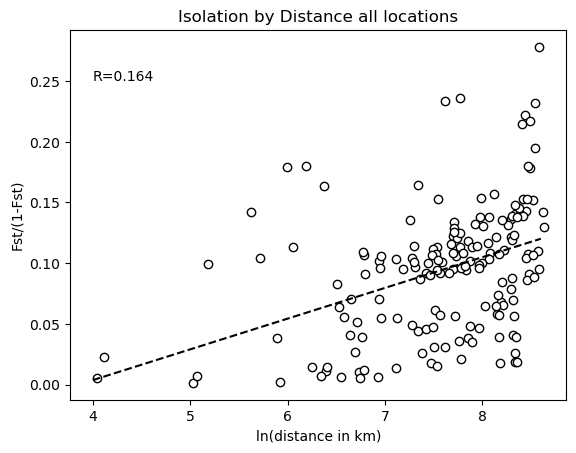

In [10]:
fig, ax = plt.subplots()
ax.scatter(geo_dist, gen_dist, edgecolor='k', facecolor='white')
ax.set_xlabel('ln(distance in km)')
ax.set_ylabel('Fst/(1-Fst)')
ax.set_title('Isolation by Distance all locations')
ax.plot(np.array([4,8.6]), reg.predict(np.array([4,8.6]).reshape(-1, 1)), c='k', ls='--')
ax.text(4,.25,f'R={reg.score(geo_dist.reshape(-1, 1), gen_dist):.3f}')
plt.show()

In [14]:
def plot_ibd_subset(ax, idx, geo_dist_mat, fst,
                   color='k', height=None, mindist=None):
    
    geo_dist = mat_to_arr(geo_dist_mat.loc[idx, idx])
    fst_arr = mat_to_arr(fst.loc[idx,idx])
    gen_dist = fst_arr/(1-fst_arr)
    
    if height is None:
        height = .9*gen_dist.max()
    if mindist is None:
        mindist = geo_dist.min()
    
    reg = LinearRegression().fit(geo_dist.reshape(-1, 1), gen_dist)
    print(reg.coef_)
    
    ax.scatter(geo_dist, gen_dist, edgecolor=color, facecolor='white')
    ax.plot(np.array([geo_dist.min(), geo_dist.max()]), 
            reg.predict(np.array([geo_dist.min(), geo_dist.max()]).reshape(-1, 1)), 
            c=color, ls='--')
    ax.text(4.046,height,f'R={reg.score(geo_dist.reshape(-1, 1), gen_dist):.3f}', 
           c=color)
    return ax

def plot_ibd_manual(ax, geo_dist, fst_arr,
                   color='k', height=None, mindist=None):
    
    gen_dist = fst_arr/(1-fst_arr)
    
    if height is None:
        height = .9*gen_dist.max()
    if mindist is None:
        mindist = geo_dist.min()
    
    reg = LinearRegression().fit(geo_dist.reshape(-1, 1), gen_dist)
    print(reg.coef_)
    
    ax.scatter(geo_dist, gen_dist, edgecolor=color, facecolor='white')
    ax.plot(np.array([mindist, geo_dist.max()]), 
            reg.predict(np.array([mindist, geo_dist.max()]).reshape(-1, 1)), 
            c=color, ls='--')
    ax.text(4.046,height,f'R={reg.score(geo_dist.reshape(-1, 1), gen_dist):.3f}', 
           c=color)
    return ax

[0.0406496]
[0.01332874]
[0.00759407]
[0.01205647]
[0.0122067]
[0.09609668]


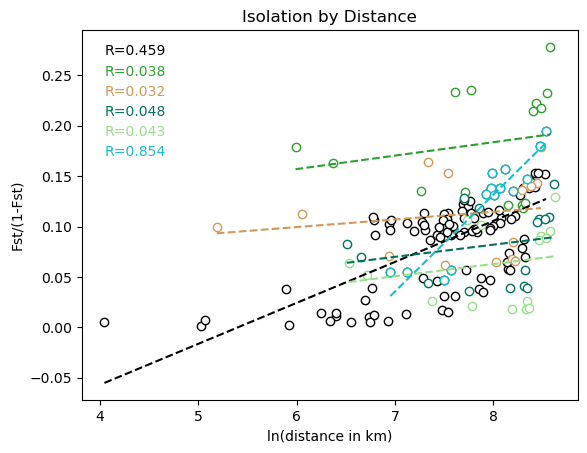

In [15]:
fst_ghn = fst.loc['GH-N'].values[4:]
geo_ghn = geo_dist_mat.loc['GH-N'].values[4:]
fst_bj = fst.loc['BJ'].values[4:]
geo_bj = geo_dist_mat.loc['BJ'].values[4:]
fst_bfk = fst.loc['BF-K'].values[4:]
geo_bfk = geo_dist_mat.loc['BF-K'].values[4:]
fst_bff = fst.loc['BF-F'].values[4:]
geo_bff = geo_dist_mat.loc['BF-F'].values[4:]
fst_mzm = fst.loc[:,'MZ-M'].values[4:-1]
geo_mzm = geo_dist_mat.loc[:,'MZ-M'].values[4:-1]


idx = ['GH-A', 'NG', 'CM', 'CF', 'CD-H', 'UG',
       'KE-W', 'KE-N', 'GA', 'CD-K', 'TZ', 'MZ-C', 'ZM', 'MW', 'MZ-M']

fig, ax = plt.subplots()
ax = plot_ibd_subset(ax, idx, geo_dist_mat, fst, height=.27)
ax = plot_ibd_manual(ax, geo_ghn, fst_ghn, color='#2ca02c', height=0.25)
ax = plot_ibd_manual(ax, geo_bj, fst_bj, color='#d1985a', height=0.23)
ax = plot_ibd_manual(ax, geo_bfk, fst_bfk, color='#02715B', height=0.21)
ax = plot_ibd_manual(ax, geo_bff, fst_bff, color='#98DF8A', height=0.19)
ax = plot_ibd_manual(ax, geo_mzm, fst_mzm, color='#17becf', height=0.17)
ax.set_xlabel('ln(distance in km)')
ax.set_ylabel('Fst/(1-Fst)')
ax.set_title('Isolation by Distance')
plt.savefig("IBD_ecotypes.svg")

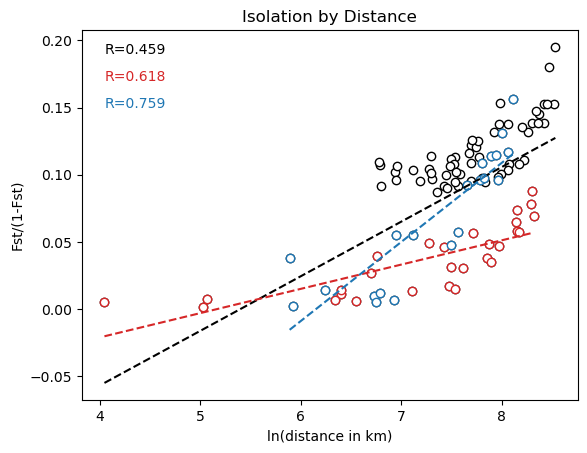

In [24]:

idx = ['GH-A', 'NG', 'CM', 'CF', 'CD-H', 'UG',
       'KE-W', 'KE-N', 'GA', 'CD-K', 'TZ', 'MZ-C', 'ZM', 'MW', 'MZ-M']
idxeq = ['GH-A', 'NG', 'CM', 'CF', 'CD-H', 'UG',
       'KE-W', 'KE-N']
idxs = ['GA', 'CD-K', 'TZ', 'MZ-C', 'ZM', 'MW', 'MZ-M']

fig, ax = plt.subplots()
ax = plot_ibd_subset(ax, idx, geo_dist_mat, fst, height=.19)
ax = plot_ibd_subset(ax, idxeq, geo_dist_mat, fst, height=.17, 
                    color='#d62728')
ax = plot_ibd_subset(ax, idxs, geo_dist_mat, fst, height=.15,
                    color='#1f77b4')

ax.set_xlabel('ln(distance in km)')
ax.set_ylabel('Fst/(1-Fst)')
ax.set_title('Isolation by Distance')
plt.savefig("IBD_eq_s_excl_GHN_BJ.svg")

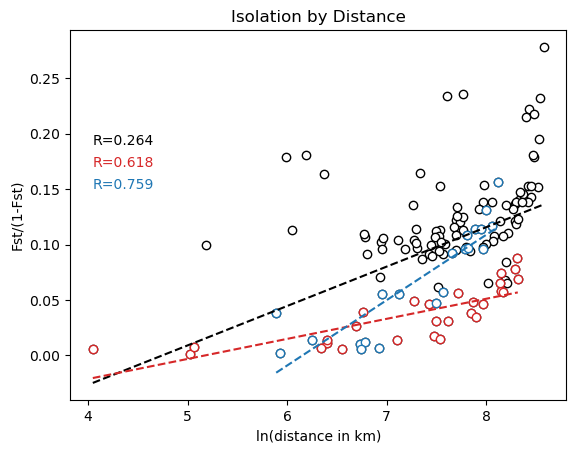

In [25]:
idx = ['GH-N', 'BJ', 'GH-A', 'NG', 'CM', 'CF', 'CD-H', 'UG',
       'KE-W', 'KE-N', 'GA', 'CD-K', 'TZ', 'MZ-C', 'ZM', 'MW', 'MZ-M']
idxeq = ['GH-A', 'NG', 'CM', 'CF', 'CD-H', 'UG',
       'KE-W', 'KE-N']
idxs = ['GA', 'CD-K', 'TZ', 'MZ-C', 'ZM', 'MW', 'MZ-M']

fig, ax = plt.subplots()
ax = plot_ibd_subset(ax, idx, geo_dist_mat, fst, height=.19)
ax = plot_ibd_subset(ax, idxeq, geo_dist_mat, fst, height=.17, 
                    color='#d62728')
ax = plot_ibd_subset(ax, idxs, geo_dist_mat, fst, height=.15,
                    color='#1f77b4')

ax.set_xlabel('ln(distance in km)')
ax.set_ylabel('Fst/(1-Fst)')
ax.set_title('Isolation by Distance')
plt.savefig("IBD_eq_s.svg")

### Without Kiribina Folonzo

In [70]:
reg = LinearRegression().fit(geo_dist.reshape(-1, 1), gen_dist)

In [72]:
reg.score(geo_dist.reshape(-1, 1), gen_dist)

0.26364171388154634

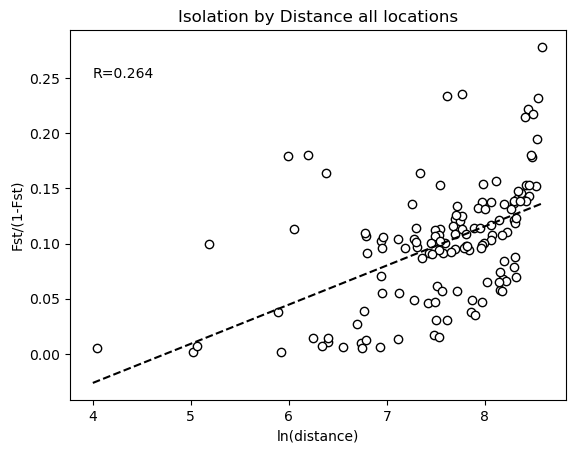

In [77]:
fig, ax = plt.subplots()
ax.scatter(geo_dist, gen_dist, edgecolor='k', facecolor='white')
ax.set_xlabel('ln(distance)')
ax.set_ylabel('Fst/(1-Fst)')
ax.set_title('Isolation by Distance all locations')
ax.plot(np.array([4,8.6]), reg.predict(np.array([4,8.6]).reshape(-1, 1)), c='k', ls='--')
ax.text(4,.25,f'R={reg.score(geo_dist.reshape(-1, 1), gen_dist):.3f}')
plt.show()

In [78]:
geo_dist_mat.index

Index(['Ghana_Northern-Region', 'Benin_Atlantique-Dept',
       'Ghana_Ashanti-Region', 'Nigeria_Ogun-State', 'Cameroon_Adamawa',
       'CAR_Ombella-MPoko', 'DRC_Haut-Uele', 'Uganda_Eastern-Region',
       'Kenya_Western-Prov', 'Kenya_Nyanza-Prov', 'Gabon_Haut-Ogooue',
       'DRC_Kinshasa', 'Tanzania_Morogoro-Region', 'Mozambique_Cabo-Delgado',
       'Zambia_Eastern-Prov', 'Malawi_Southern-Region', 'Mozambique_Maputo'],
      dtype='object')

In [124]:
def plot_ibd_subset(ax, idx, geo_dist_mat, fst,
                   color='k', height=None, mindist=None):
    
    geo_dist = mat_to_arr(geo_dist_mat.loc[idx, idx])
    fst_arr = mat_to_arr(fst.loc[idx,idx])
    gen_dist = fst_arr/(1-fst_arr)
    
    if height is None:
        height = .9*gen_dist.max()
    if mindist is None:
        mindist = geo_dist.min()
    
    reg = LinearRegression().fit(geo_dist.reshape(-1, 1), gen_dist)
    
    ax.scatter(geo_dist, gen_dist, edgecolor=color, facecolor='white')
    ax.plot(np.array([geo_dist.min(), geo_dist.max()]), 
            reg.predict(np.array([geo_dist.min(), geo_dist.max()]).reshape(-1, 1)), 
            c=color, ls='--')
    ax.text(mindist,height,f'R={reg.score(geo_dist.reshape(-1, 1), gen_dist):.3f}', 
           c=color)
    return ax

def plot_ibd_manual(ax, geo_dist, fst_arr,
                   color='k', height=None, mindist=None):
    
    gen_dist = fst_arr/(1-fst_arr)
    
    if height is None:
        height = .9*gen_dist.max()
    if mindist is None:
        mindist = geo_dist.min()
    
    reg = LinearRegression().fit(geo_dist.reshape(-1, 1), gen_dist)
    
    ax.scatter(geo_dist, gen_dist, edgecolor=color, facecolor='white')
    ax.plot(np.array([mindist, geo_dist.max()]), 
            reg.predict(np.array([mindist, geo_dist.max()]).reshape(-1, 1)), 
            c=color, ls='--')
    ax.text(mindist,height,f'R={reg.score(geo_dist.reshape(-1, 1), gen_dist):.3f}', 
           c=color)
    return ax

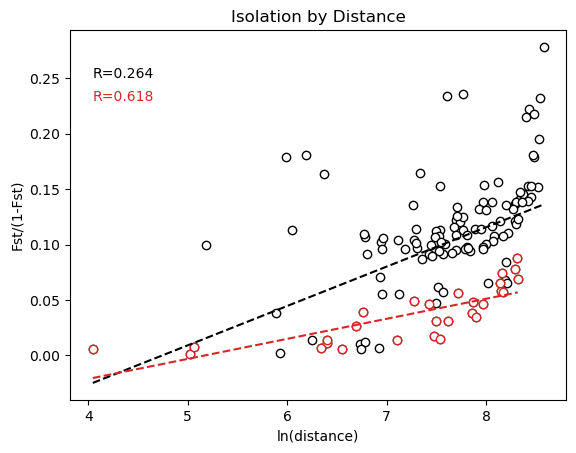

In [97]:
idx = ['Ghana_Ashanti-Region', 'Nigeria_Ogun-State', 'Cameroon_Adamawa',
       'CAR_Ombella-MPoko', 'DRC_Haut-Uele', 'Uganda_Eastern-Region',
       'Kenya_Western-Prov', 'Kenya_Nyanza-Prov']
fig, ax = plt.subplots()
ax = plot_ibd_subset(ax, fst.index, geo_dist_mat, fst)
ax = plot_ibd_subset(ax, idx, geo_dist_mat, fst, color='#d62728', height=0.23)
ax.set_xlabel('ln(distance)')
ax.set_ylabel('Fst/(1-Fst)')
ax.set_title('Isolation by Distance')
plt.show()

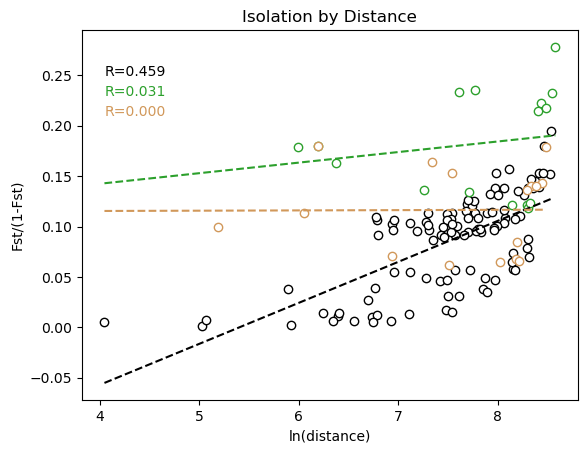

In [120]:
fst_ghn = fst.loc['Ghana_Northern-Region'].values[1:]
geo_ghn = geo_dist_mat.loc['Ghana_Northern-Region'].values[1:]
fst_bj = np.concatenate([fst.iloc[:1,1], fst.loc['Benin_Atlantique-Dept'].values[2:]])
geo_bj = np.concatenate([geo_dist_mat.iloc[:1,1], geo_dist_mat.loc['Benin_Atlantique-Dept'].values[2:]])


idx = ['Ghana_Ashanti-Region', 'Nigeria_Ogun-State', 'Cameroon_Adamawa',
       'CAR_Ombella-MPoko', 'DRC_Haut-Uele', 'Uganda_Eastern-Region',
       'Kenya_Western-Prov', 'Kenya_Nyanza-Prov', 'Gabon_Haut-Ogooue',
       'DRC_Kinshasa', 'Tanzania_Morogoro-Region', 'Mozambique_Cabo-Delgado',
       'Zambia_Eastern-Prov', 'Malawi_Southern-Region', 'Mozambique_Maputo']

fig, ax = plt.subplots()
ax = plot_ibd_subset(ax, idx, geo_dist_mat, fst, height=.25)
ax = plot_ibd_manual(ax, geo_ghn, fst_ghn, color='#2ca02c', height=0.23, mindist = geo_dist.min())
ax = plot_ibd_manual(ax, geo_bj, fst_bj, color='#d1985a', height=0.21, mindist = geo_dist.min())
ax.set_xlabel('ln(distance)')
ax.set_ylabel('Fst/(1-Fst)')
ax.set_title('Isolation by Distance')
plt.show()

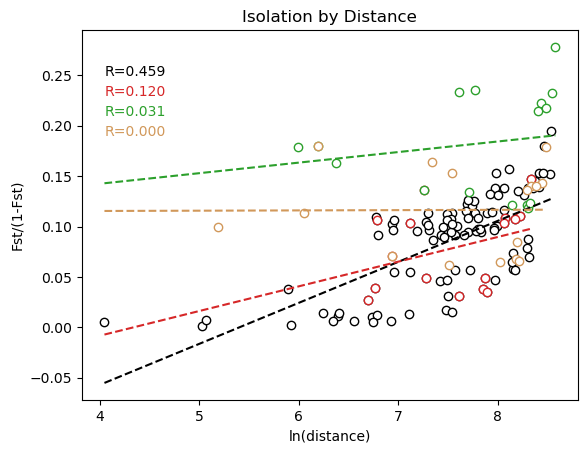

In [119]:
fst_ghn = fst.loc['Ghana_Northern-Region'].values[1:]
geo_ghn = geo_dist_mat.loc['Ghana_Northern-Region'].values[1:]
fst_bj = np.concatenate([fst.iloc[:1,1], fst.loc['Benin_Atlantique-Dept'].values[2:]])
geo_bj = np.concatenate([geo_dist_mat.iloc[:1,1], geo_dist_mat.loc['Benin_Atlantique-Dept'].values[2:]])
fst_cm = np.concatenate([fst.loc[:'Nigeria_Ogun-State','Cameroon_Adamawa'], fst.loc['Cameroon_Adamawa','CAR_Ombella-MPoko':]])
geo_cm = np.concatenate([geo_dist_mat.loc[:'Nigeria_Ogun-State','Cameroon_Adamawa'], geo_dist_mat.loc['Cameroon_Adamawa','CAR_Ombella-MPoko':]])

idx = ['Ghana_Ashanti-Region', 'Nigeria_Ogun-State', 'Cameroon_Adamawa',
       'CAR_Ombella-MPoko', 'DRC_Haut-Uele', 'Uganda_Eastern-Region',
       'Kenya_Western-Prov', 'Kenya_Nyanza-Prov', 'Gabon_Haut-Ogooue',
       'DRC_Kinshasa', 'Tanzania_Morogoro-Region', 'Mozambique_Cabo-Delgado',
       'Zambia_Eastern-Prov', 'Malawi_Southern-Region', 'Mozambique_Maputo']

fig, ax = plt.subplots()
ax = plot_ibd_subset(ax, idx, geo_dist_mat, fst, height=.25)
ax = plot_ibd_manual(ax, geo_cm, fst_cm, color='#d62728', height=0.23, mindist = geo_dist.min())
ax = plot_ibd_manual(ax, geo_ghn, fst_ghn, color='#2ca02c', height=0.21, mindist = geo_dist.min())
ax = plot_ibd_manual(ax, geo_bj, fst_bj, color='#d1985a', height=0.19, mindist = geo_dist.min())
ax.set_xlabel('ln(distance)')
ax.set_ylabel('Fst/(1-Fst)')
ax.set_title('Isolation by Distance')
plt.show()

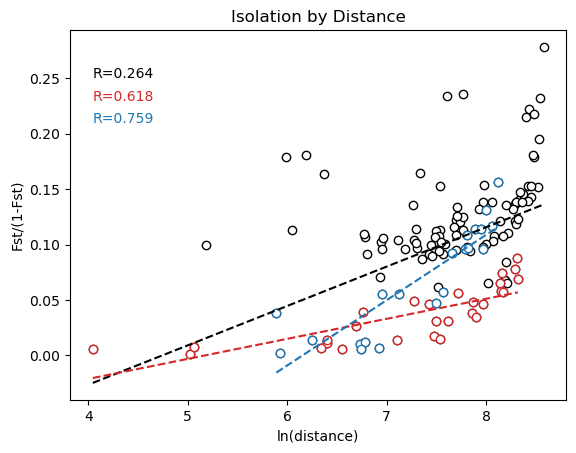

In [125]:
idx1 = ['Ghana_Ashanti-Region', 'Nigeria_Ogun-State', 'Cameroon_Adamawa',
       'CAR_Ombella-MPoko', 'DRC_Haut-Uele', 'Uganda_Eastern-Region',
       'Kenya_Western-Prov', 'Kenya_Nyanza-Prov']
idx2 = ['Gabon_Haut-Ogooue',
       'DRC_Kinshasa', 'Tanzania_Morogoro-Region', 'Mozambique_Cabo-Delgado',
       'Zambia_Eastern-Prov', 'Malawi_Southern-Region', 'Mozambique_Maputo']
fig, ax = plt.subplots()
ax = plot_ibd_subset(ax, fst.index, geo_dist_mat, fst)
ax = plot_ibd_subset(ax, idx1, geo_dist_mat, fst, color='#d62728', height=0.23)
ax = plot_ibd_subset(ax, idx2, geo_dist_mat, fst, color='#1f77b4', height=0.21, 
                     mindist = geo_dist.min())
ax.set_xlabel('ln(distance)')
ax.set_ylabel('Fst/(1-Fst)')
ax.set_title('Isolation by Distance')
plt.show()

In [ ]:
['Ghana_Northern-Region', 'Benin_Atlantique-Dept',
       'Ghana_Ashanti-Region', 'Nigeria_Ogun-State', 'Cameroon_Adamawa',
       'CAR_Ombella-MPoko', 'DRC_Haut-Uele', 'Uganda_Eastern-Region',
       'Kenya_Western-Prov', 'Kenya_Nyanza-Prov', 'Gabon_Haut-Ogooue',
       'DRC_Kinshasa', 'Tanzania_Morogoro-Region', 'Mozambique_Cabo-Delgado',
       'Zambia_Eastern-Prov', 'Malawi_Southern-Region', 'Mozambique_Maputo']

In [20]:
idx = ['Gabon_Haut-Ogooue',
       'DRC_Kinshasa', 'Tanzania_Morogoro-Region', 'Mozambique_Cabo-Delgado',
       'Zambia_Eastern-Prov', 'Malawi_Southern-Region', 'Mozambique_Maputo']
mat_to_arr(fst.loc[idx, idx])/(1-mat_to_arr(fst.loc[idx, idx]))

array([0.03822547, 0.11373859, 0.11672382, 0.10834923, 0.11432517,
       0.15668081, 0.09590209, 0.09634323, 0.09202104, 0.09729963,
       0.13084266, 0.01415406, 0.0099987 , 0.01209945, 0.05727624,
       0.00657971, 0.00553164, 0.04737087, 0.00198491, 0.05499907,
       0.05514916])

In [21]:
mat_to_arr(geo_dist_mat.loc[idx,idx])

array([5.890337917860377, 7.890340446462899, 8.059226711666252,
       7.805734415493263, 7.9476034961311735, 8.116749500469172,
       7.7837955697324785, 7.964662319986804, 7.6589026471513435,
       7.821189333167707, 8.002710029694269, 6.24619953502978,
       6.734596458159019, 6.785816479595866, 7.5661765958332055,
       6.9247126982149725, 6.74609130483932, 7.493861518486843,
       5.9246743943529285, 7.120065233302944, 6.95387940091648],
      dtype=object)

In [ ]:
geo_dist = mat_to_arr(geo_dist_mat.loc[idx, idx])
fst_arr = mat_to_arr(fst.loc[idx,idx])
    gen_dist = fst_arr/(1-fst_arr)